# The dataset can be downloaded from the following Kaggle link:
# https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trungle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


READING DATASET

In [2]:
dataset_path = '/kaggle/input/financial-sentiment-analysis/data.csv'
data = pd.read_csv(dataset_path)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [3]:
# Check whether null cells appear in the dataset
data.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

PREPROCESSING THE DATASET

In [4]:
# Normalize the text
def text_normalize(text):
    # Lowercasing
    text = text.lower()
    
    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    # Stemming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)
    
    return text

In [5]:
# Intialize Tfidf vectorize
vectorizer = TfidfVectorizer(max_features = 2000)
X = vectorizer.fit_transform(data['Sentence']).toarray()

In [6]:
# Include bias to X
intercepts = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercepts, X), axis = 1)

In [7]:
# Convert the categorical values to numerical values
data['Sentiment'] = data['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# One-hot_encoding
n_classes = data['Sentiment'].nunique()
n_samples = data['Sentiment'].size

y = data['Sentiment'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1

TRAIN/TEST/VAL SPLIT

In [8]:
# Hyperparameters
val_size = 0.2
test_size = 0.125
random_state = 42
is_shuffle = True

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded, test_size = val_size, random_state = random_state, shuffle = is_shuffle
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4673, 2001), (1169, 2001), (4673, 3), (1169, 3))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size = test_size, random_state = random_state, shuffle = is_shuffle
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4088, 2001), (585, 2001), (4088, 3), (585, 3))

FUNCTIONS USED IN THIS MODEL

In [11]:
# Softmax function
def softmax(z):
    numerator = np.exp(z)
    denominator = np.exp(z).sum(axis = 1)[:, None]
    return numerator/denominator

In [12]:
# Predict function
def predict(X, theta):
    z = np.dot(X, theta)
    y_hat = softmax(z)
    return y_hat

In [13]:
# Compute Loss
def compute_loss(y_hat, y):
    N = y.size
    loss = np.sum(y * np.log(y_hat))
    return -(loss/N)

In [14]:
# Compute gradient
def compute_gradient(X, y_hat, y):
    N = y.size
    gradient = np.dot(X.T, y_hat - y)
    return gradient/N

In [15]:
# Update parameters
def update_theta(theta, gradient, lr):
    theta = theta - lr*gradient
    return theta

In [16]:
# Compute accuracy rate
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta)
    accuracy = (np.argmax(y_hat, axis = 1) == np.argmax(y, axis = 1)).mean()
    return accuracy

SOFTMAX MODEL

In [17]:
# Intialize the hyperparameters
lr = 0.01
epochs = 100
batch_size = 32
n_features = X_train.shape[1]
np.random.seed(random_state)
theta = np.random.uniform(size = (n_features, n_classes))

In [18]:
# Training model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_batch_losses = []
    val_batch_losses = []
    train_batch_accs = []
    val_batch_accs = []
    
    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]
        
        # TRAINING PHASE
        
        # Predict output
        y_hat = predict(X_i, theta)
        
        # Compute loss
        train_loss = compute_loss(y_hat, y_i)
        train_batch_losses.append(train_loss)
        
        # Compute gradient
        gradient = compute_gradient(X_i, y_hat, y_i)
        
        # Update theta
        theta = update_theta(theta, gradient, lr)
        
        # Compute accuracy
        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)
        
        # VALIDATION PHASE
        
        # Predict output
        y_val_hat = predict(X_val, theta)
        
        # Compute loss
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)
        
        # Compute accuracy
        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
    
    # Training parameters
    train_batch_loss = sum(train_batch_losses)/len(train_batch_losses)
    train_losses.append(train_batch_loss)
    train_batch_acc = sum(train_batch_accs)/len(train_batch_accs)
    train_accs.append(train_batch_acc)
    
    # Validation parameters
    val_batch_loss = sum(val_batch_losses)/len(val_batch_losses)
    val_losses.append(val_batch_loss)
    val_batch_acc = sum(val_batch_accs)/len(val_batch_accs)
    val_accs.append(val_batch_acc)
    
    # Printing Epoch's loss 
    print(f'\tEpoch {epoch+1}:\tTraining loss: {train_batch_loss:.3f} \tTraining Accuracy: {val_batch_loss:.3f}')

	Epoch 1:	Training loss: 0.356 	Training Accuracy: 0.352
	Epoch 2:	Training loss: 0.353 	Training Accuracy: 0.349
	Epoch 3:	Training loss: 0.350 	Training Accuracy: 0.347
	Epoch 4:	Training loss: 0.349 	Training Accuracy: 0.345
	Epoch 5:	Training loss: 0.347 	Training Accuracy: 0.344
	Epoch 6:	Training loss: 0.346 	Training Accuracy: 0.343
	Epoch 7:	Training loss: 0.345 	Training Accuracy: 0.342
	Epoch 8:	Training loss: 0.345 	Training Accuracy: 0.341
	Epoch 9:	Training loss: 0.344 	Training Accuracy: 0.341
	Epoch 10:	Training loss: 0.343 	Training Accuracy: 0.340
	Epoch 11:	Training loss: 0.343 	Training Accuracy: 0.340
	Epoch 12:	Training loss: 0.343 	Training Accuracy: 0.339
	Epoch 13:	Training loss: 0.342 	Training Accuracy: 0.339
	Epoch 14:	Training loss: 0.342 	Training Accuracy: 0.339
	Epoch 15:	Training loss: 0.342 	Training Accuracy: 0.338
	Epoch 16:	Training loss: 0.341 	Training Accuracy: 0.338
	Epoch 17:	Training loss: 0.341 	Training Accuracy: 0.338
	Epoch 18:	Training los

PLOTING RESULTS

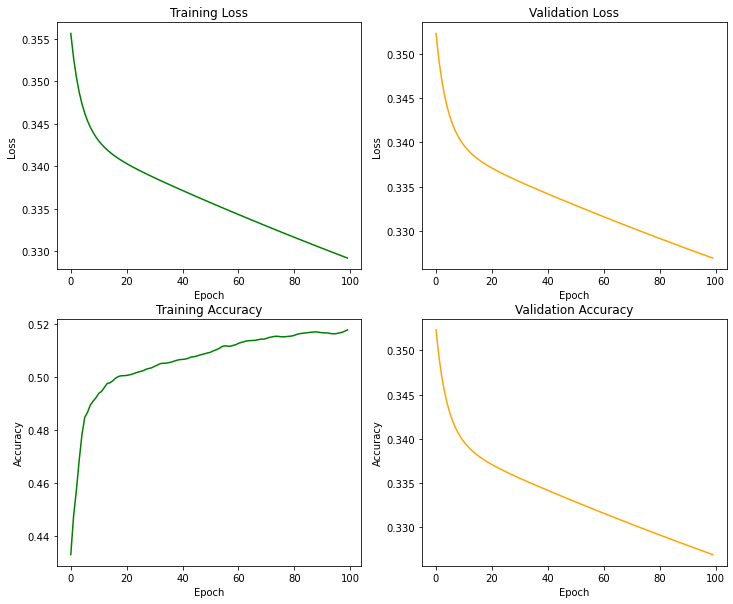

In [19]:
fig, ax = plt.subplots(2,2,figsize = (12,10))

ax[0,0].plot(train_losses, 'green')
ax[0,0].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0,0].set_title('Training Loss')

ax[0,1].plot(val_losses, 'orange')
ax[0,1].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0,1].set_title('Validation Loss')

ax[1,0].plot(train_accs, 'green')
ax[1,0].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1,0].set_title('Training Accuracy')

ax[1,1].plot(val_losses, 'orange')
ax[1,1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1,1].set_title('Validation Accuracy')

plt.show()

EVALUATE THE MODEL

In [20]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation:')
print(f'Validation Accuracy: {val_set_acc}')
print(f'Testing Accuracy: {test_set_acc}')

Evaluation:
Validation Accuracy: 0.514114627887083
Testing Accuracy: 0.5606837606837607
